# PROYECTO ENTREGA 2
## Integrantes:
- LUIS ALBERTO PINILLA GUZMAN - 202221306 - l.pinillag@uniandes.edu.co
- JUAN ESTEBAN ALVAREZ GARCIA - 202212030 - je.alvarezg1@uniandes.edu.co
- LUIS FELIPE SALES GALVIZ - 202211531 - l.sales@uniandes.edu.co
- NICOLAS PRADA QUINTERO - 202113867 - n.pradaq@uniandes.edu.co

Aqui se encuentra la implementación del modelo matemático del caso base con:
- Un solo depósito  
- Flota homogénea  
- Sin ventanas de tiempo  
- Sin múltiples depósitos  
- Sin restricciones adicionales 

---

### **Archivos de entrada**
Ubicados en `./data/`:
- `clients.csv`
- `vehicles.csv`
- `depots.csv`
- `parameters_base.csv`



In [1]:
# IMPORTACIONES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyomo.environ import (
    ConcreteModel, Set, Param, Var, Objective, Constraint,
    Binary, NonNegativeReals, value
)
from pyomo.opt import SolverFactory

from procesado_datos import (
    cargar_datos,
    preparar_datos_pyomo
)

from modelo_pyomo import construir_modelo

from utilidades import (
    generar_archivo_verificacion
)

pd.set_option('display.max_columns', None)


In [2]:
# CARGA DE DATOS

ruta_data = "data/"

datos_brutos = cargar_datos(
    ruta_data + "clients.csv",
    ruta_data + "vehicles.csv",
    ruta_data + "depots.csv",
    ruta_data + "parameters_base.csv"
)

clientes_df = datos_brutos["clients"]
vehiculos_df = datos_brutos["vehicles"]
deposito_df = datos_brutos["depots"]

print("Clientes:")
display(clientes_df.head())

print("Vehículos:")
display(vehiculos_df)

print("Depósito:")
display(deposito_df)

print("Parámetros base:")
print("Fuel price:", datos_brutos["fuel_price"])
print("Fuel efficiency:", datos_brutos["fuel_efficiency"])


Clientes:


,ClientID,StandardizedID,LocationID,Latitude,Longitude,Demand
0,1,C001,2,4.597954,-74.098938,13
1,2,C002,3,4.687821,-74.075571,15
2,3,C003,4,4.709494,-74.107085,12
3,4,C004,5,4.605029,-74.097280,15
4,5,C005,6,4.648464,-74.164641,20


Vehículos:


,VehicleID,StandardizedID,Capacity,Range
0,1,V001,130,170
1,2,V002,140,200
2,3,V003,120,180
3,4,V004,100,90


Depósito:


,DepotID,StandardizedID,LocationID,Longitude,Latitude
0,1,CD01,1,-74.153536,4.743359


Parámetros base:
Fuel price: 16300.0
Fuel efficiency: 30.0


## Formulación del Modelo Matemático

La formulación implementa un CVRP con:

- Un único depósito
- Flota homogénea
- Restricciones de capacidad
- Restricciones de rango
- Eliminación de subciclos mediante MTZ
- Cálculo de costos basado en:
  - Distancia total
  - Tiempo total
  - Consumo de combustible

La función objetivo implementada es:

$$
\min Z = \sum_{v \in V} C_{\text{fixed}}\, y_v
       + \sum_{v \in V} C_{\text{dist}}\, d_v
       + \sum_{v \in V} C_{\text{time}}\, t_v
       + C_{\text{fuel}}
$$


Donde:
- yv indica si el vehículo es activado.
- dv es la distancia recorrida por el vehículo.
- tv es el tiempo total de operación.
- El costo de combustible depende del rendimiento (km/gal) y del precio por galón.


In [3]:
# PROCESAMIENTO

from procesado_datos import preparar_datos_pyomo
from modelo_pyomo import construir_modelo

datos_pyomo = preparar_datos_pyomo(
    "data/clients.csv",
    "data/vehicles.csv",
    "data/depots.csv",
    "data/parameters_base.csv"
)

modelo = construir_modelo(datos_pyomo)
modelo

In [4]:
#SOLVER

solver = SolverFactory("glpk")
print("Pyomo ejecutable detectado:", solver.executable())

modelo.pprint()


Pyomo ejecutable detectado: C:\Users\luisf\anaconda3\envs\pyomo_env\Library\bin\glpsol.exe
3 Set Declarations
    Clients : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    7 : {1, 2, 3, 4, 5, 6, 7}
    N : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    8 : {0, 1, 2, 3, 4, 5, 6, 7}
    V : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {1, 2, 3, 4}

4 Param Declarations
    capacidad : Size=4, Index=V, Domain=PositiveReals, Default=None, Mutable=False
        Key : Value
          1 : 130.0
          2 : 140.0
          3 : 120.0
          4 : 100.0
    demanda : Size=7, Index=Clients, Domain=NonNegativeReals, Default=None, Mutable=False
        Key : Value
          1 :    13
          2 :    15
          3 :    12
          4 :    15
          5 :    20
          6 :

In [5]:
# RESULTADO

resultado = solver.solve(modelo, tee=True)

print("\nEstado del solver:", resultado.solver.status)
print("Terminación:", resultado.solver.termination_condition)


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\luisf\AppData\Local\Temp\tmpypspyfeu.glpk.raw --wglp C:\Users\luisf\AppData\Local\Temp\tmpe9n3wcxa.glpk.glp
 --cpxlp C:\Users\luisf\AppData\Local\Temp\tmpuh03ru74.pyomo.lp
Reading problem data from 'C:\Users\luisf\AppData\Local\Temp\tmpuh03ru74.pyomo.lp'...
C:\Users\luisf\AppData\Local\Temp\tmpuh03ru74.pyomo.lp:3448: warning: lower bound of variable 'x2' redefined
C:\Users\luisf\AppData\Local\Temp\tmpuh03ru74.pyomo.lp:3448: warning: upper bound of variable 'x2' redefined
306 rows, 252 columns, 2044 non-zeros
224 integer variables, all of which are binary
3672 lines were read
Writing problem data to 'C:\Users\luisf\AppData\Local\Temp\tmpe9n3wcxa.glpk.glp'...
3135 lines were written
GLPK Integer Optimizer 5.0
306 rows, 252 columns, 2044 non-zeros
224 integer variables, all of which are binary
Preprocessing...
278 rows, 252 columns, 2016 non-zeros
224 integer variables, all of which are binary
Sca

In [6]:
# CREA DICCIONARIO CON SOLUCION

solucion = {(v, i, j): modelo.x[v,i,j].value for v in modelo.V for i in modelo.N for j in modelo.N}
print(solucion)

{(1, 0, 0): None, (1, 0, 1): 0.0, (1, 0, 2): 0.0, (1, 0, 3): 0.0, (1, 0, 4): 0.0, (1, 0, 5): 0.0, (1, 0, 6): 0.0, (1, 0, 7): 0.0, (1, 1, 0): 0.0, (1, 1, 1): None, (1, 1, 2): 0.0, (1, 1, 3): 0.0, (1, 1, 4): 0.0, (1, 1, 5): 0.0, (1, 1, 6): 0.0, (1, 1, 7): 0.0, (1, 2, 0): 0.0, (1, 2, 1): 0.0, (1, 2, 2): None, (1, 2, 3): 0.0, (1, 2, 4): 0.0, (1, 2, 5): 0.0, (1, 2, 6): 0.0, (1, 2, 7): 0.0, (1, 3, 0): 0.0, (1, 3, 1): 0.0, (1, 3, 2): 0.0, (1, 3, 3): None, (1, 3, 4): 0.0, (1, 3, 5): 0.0, (1, 3, 6): 0.0, (1, 3, 7): 0.0, (1, 4, 0): 0.0, (1, 4, 1): 0.0, (1, 4, 2): 0.0, (1, 4, 3): 0.0, (1, 4, 4): None, (1, 4, 5): 0.0, (1, 4, 6): 0.0, (1, 4, 7): 0.0, (1, 5, 0): 0.0, (1, 5, 1): 0.0, (1, 5, 2): 0.0, (1, 5, 3): 0.0, (1, 5, 4): 0.0, (1, 5, 5): None, (1, 5, 6): 0.0, (1, 5, 7): 0.0, (1, 6, 0): 0.0, (1, 6, 1): 0.0, (1, 6, 2): 0.0, (1, 6, 3): 0.0, (1, 6, 4): 0.0, (1, 6, 5): 0.0, (1, 6, 6): None, (1, 6, 7): 0.0, (1, 7, 0): 0.0, (1, 7, 1): 0.0, (1, 7, 2): 0.0, (1, 7, 3): 0.0, (1, 7, 4): 0.0, (1, 7, 5): 0.0, 

In [ ]:
#ALMACENAR RUTAS

rutas_por_vehiculo = {}

for v in modelo.V:
    ruta = [0] 
    siguiente = 0
    visitados = set()
    
    while True:
        encontrados = [j for j in modelo.N if j not in visitados and modelo.x[v, siguiente, j].value == 1]
        if not encontrados:
            break
        siguiente = encontrados[0]
        ruta.append(siguiente)
        visitados.add(siguiente)

    ruta.append(0)
    if len(ruta) > 2:
        rutas_por_vehiculo[v] = ruta
        print(f"Vehículo {v}: {ruta}")
    else:
        rutas_por_vehiculo[v] = []
        print(f"Vehículo {v}: no tiene clientes asignados")


Vehículo 1: no tiene clientes asignados
Vehículo 2: no tiene clientes asignados
Vehículo 3: [0, 5, 6, 1, 4, 7, 2, 3, 0, 0]
Vehículo 4: no tiene clientes asignados


In [8]:
#COORDENADAS

depot_id = 0
depot_lat = deposito_df['Latitude'].values[0]
depot_lon = deposito_df['Longitude'].values[0]

coords = {0: (depot_lon, depot_lat)} 
for idx, row in clientes_df.iterrows():
    coords[row['LocationID']] = (row['Longitude'], row['Latitude'])


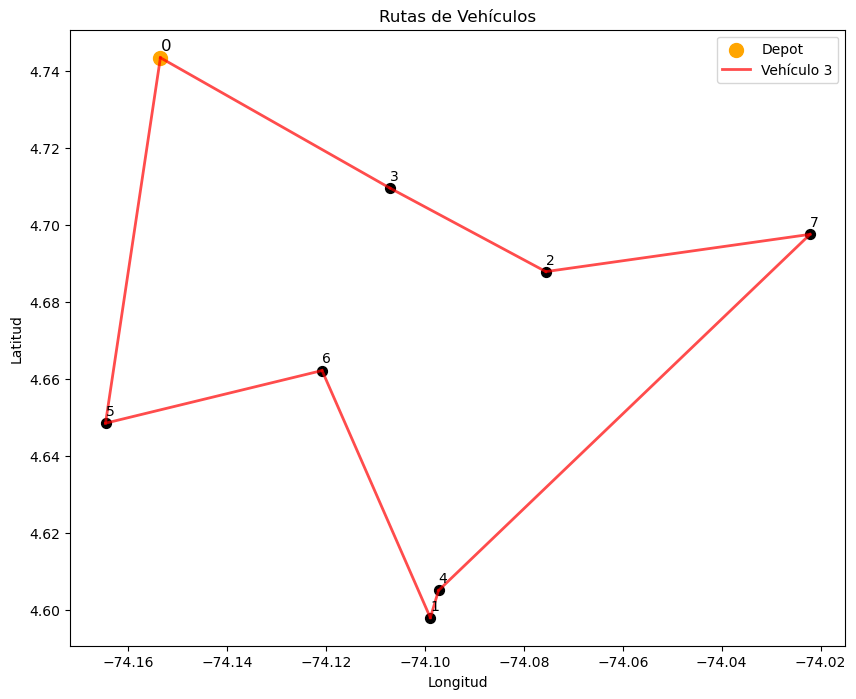

In [ ]:
#VISUALIZACION

import matplotlib.pyplot as plt

coords = {}

coords[0] = (deposito_df.iloc[0]['Longitude'], deposito_df.iloc[0]['Latitude'])

for idx, row in clientes_df.iterrows():
    coords[row['ClientID']] = (row['Longitude'], row['Latitude'])

colores = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'brown']

plt.figure(figsize=(10,8))

for nodo, (lon, lat) in coords.items():
    if nodo == 0:
        plt.scatter(lon, lat, c='orange', s=100, label='Depot')
        plt.text(lon, lat+0.002, str(nodo), fontsize=12)
    else:
        plt.scatter(lon, lat, c='black', s=50)
        plt.text(lon, lat+0.002, str(nodo), fontsize=10)

for idx, (v, ruta) in enumerate(rutas_por_vehiculo.items()):
    if len(ruta) <= 2:
        continue
    for k in range(len(ruta)-1):
        i, j = ruta[k], ruta[k+1]
        plt.plot([coords[i][0], coords[j][0]],
                 [coords[i][1], coords[j][1]],
                 c=colores[idx % len(colores)], linewidth=2, alpha=0.7, label=f'Vehículo {v}' if k==0 else "")

plt.title("Rutas de Vehículos")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
from base_case_verification import SolutionValidator

clientes_df = pd.read_csv("data/clients.csv")
cliente_demandas = {int(row.ClientID): int(row.Demand) for _, row in clientes_df.iterrows()}

rows = []
for v_id, ruta in rutas_por_vehiculo.items():
    if len(ruta) <= 2:
        route_sequence = "CDA-CDA" 
        demands_satisfied = ["0"]
        initial_load = 0
        clients_served = 0
    else:
        route_sequence = "-".join([f"C{n:03d}" if n != 0 else "CDA" for n in ruta])
        demands_satisfied = [str(cliente_demandas[n]) for n in ruta if n != 0]
        if not demands_satisfied:
            demands_satisfied = ["0"]
        initial_load = sum(int(d) for d in demands_satisfied)
        clients_served = len([d for d in demands_satisfied if d != "0"])

    rows.append({
        "VehicleId": f"V{v_id:03d}",
        "DepotId": "CDA",
        "RouteSequence": route_sequence,
        "InitialLoad": initial_load,
        "ClientsServed": clients_served,
        "DemandsSatisfied": "-".join(demands_satisfied)
    })

df_resultados = pd.DataFrame(rows)
df_resultados.to_csv("resultados/resultados.csv", index=False)
print("Archivo resultados/resultados.csv generado con éxito.")

validator = SolutionValidator(
    distance_method="haversine",
    cache_file="distance_cache.json",
    solution_file="resultados/resultados.csv"
)

resultado = validator.validate_solution()

if resultado["feasible"]:
    print("SOLUCIÓN FACTIBLE")
else:
    print("SOLUCIÓN NO FACTIBLE")
    for err in resultado["errors"]:
        print(f"- {err}")


Archivo resultados/resultados.csv generado con éxito.
SOLUCIÓN FACTIBLE
